In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Data Preparation
train = pd.read_csv("C:\\Users\\Zver\\Downloads\\training.csv")
test = pd.read_csv("C:\\Users\\Zver\\Downloads\\test.csv")

In [4]:
train_x_a = train.drop('price', axis=1) #Get features
train_y  = train[['price']] #Get Target

In [5]:
# Columns that have null values
nan_train_columns = list(train.columns[train.isnull().any()])
print(nan_train_columns)

# Fill missing values of nan_columns with the average of nan_columns (median) and create dataset
train_x_a_median = train_x_a.median() #Store as variable to fill test data later
train_x_b = train_x_a.fillna(train_x_a_median)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


In [6]:
# Identify in which rows 'price' has null values 
null_prices=train_y[train_y['price'].isnull()].index.tolist()
print(null_prices)

# Drop rows that 'price' has null values 
train_y=train_y.drop(null_prices)
train_x_b=train_x_b.drop(null_prices)

# for checking
#train_x_b.isnull().any()

[18, 37, 47, 69, 71, 81, 82, 100, 107]


In [7]:
# Columns that contains categorical values
categorical_columns = train_x_b.select_dtypes(include=['object'])
train_x_c=pd.Categorical(categorical_columns)

# Encode the categorical values
train_x_d = pd.get_dummies(train_x_b)
train_x_d.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,104.3,188.8,67.2,56.2,2410.0,141.0,3.31,3.15,9.5,114.0,...,0,0,0,0,0,0,0,0,1,0
1,94.5,170.2,63.8,53.5,2024.0,97.0,3.15,3.29,9.4,69.0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
#Get all coninous variable columns
continuous_columns = [i for i in train_x_b if i not in categorical_columns]

# Scale our dataframe with standardization
scaler = StandardScaler()
scaler.fit(train_x_d[continuous_columns])
train_x_e = train_x_d.copy()
train_x_e[continuous_columns] = scaler.transform(train_x_d[continuous_columns])

In [9]:
test_x_a = test.drop('price', axis=1) #Get features
test_y = test[['price']] #Get Target

In [10]:
# Columns that have null values
nan_test_columns = list(test.columns[test.isnull().any()])
print(nan_test_columns)

# Fill missing values of nan_columns with the average of nan_columns (median) and create dataset
test_x_a_median = test_x_a.median() #Store as variable to fill test data later
test_x_b = test_x_a.fillna(test_x_a_median)

['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


In [11]:
# Identify in which rows 'price' has null values 
null_prices=test_y[test_y['price'].isnull()].index.tolist()
print(null_prices)

# Drop rows that 'price' has null values 
test_y=test_y.drop(null_prices)
test_x_b=test_x_b.drop(null_prices)

# for checking
#test_x_b.isnull().any()

[10]


In [12]:
# Columns that contains categorical values
categorical_columns = test_x_b.select_dtypes(include=['object'])
test_x_c=pd.Categorical(categorical_columns)

# Encode the categorical values
test_x_d = pd.get_dummies(test_x_b)
test_x_d.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi
0,105.8,192.7,71.4,55.7,2954.0,136.0,3.19,3.40,8.5,110.0,...,0,0,0,0,0,0,0,0,1,0
1,96.5,175.4,62.5,54.1,2372.0,110.0,3.15,3.58,9.0,86.0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
#Get all coninous variable columns
continuous_columns = [i for i in test_x_b if i not in categorical_columns]

# Scale our dataframe with standardization
scaler = StandardScaler()
scaler.fit(test_x_d[continuous_columns])
test_x_e = test_x_d.copy()
test_x_e[continuous_columns] = scaler.transform(test_x_d[continuous_columns])

## KNN REGGRESSOR TO PREDICT CAR PRICES 

### a) Training Vs Validation Plot:

In [14]:
# Split the data: 80% training, 20% validation
from sklearn.model_selection import train_test_split
train_split_x, val_split_x, train_split_y, val_split_y = train_test_split(train_x_e, train_y, test_size=0.2, random_state=0)

In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn_training_errors = []
knn_validation_error = []
for k in range(1, 30):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_split_x, train_split_y)
    train_pred = knn.predict(train_split_x)
    val_pred = knn.predict(val_split_x)
    train_error = mean_squared_error(train_split_y, train_pred)
    val_error = mean_squared_error(val_split_y, val_pred)
    knn_training_errors.append(train_error)
    knn_validation_error.append(val_error)

Text(0, 0.5, 'MSE')

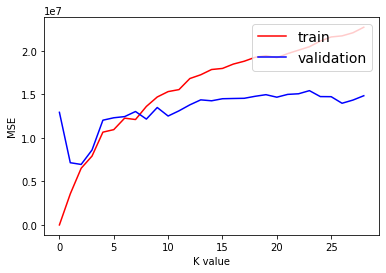

In [16]:
# training vs validation plot
plt.plot(knn_training_errors, 'r-', label = 'train')
plt.plot(knn_validation_error, 'b-', label = 'validation')
plt.legend(loc='upper right', fontsize = 14)
plt.xlabel('K value')
plt.ylabel('MSE')

### b) Test your model:

In [17]:
# Create KNN Model with the best parameters
best_knn = KNeighborsRegressor(n_neighbors=3)
best_knn.fit(train_split_x, train_split_y)

KNeighborsRegressor(n_neighbors=3)

In [18]:
knn_preds = best_knn.predict(val_split_x)

In [19]:
# Mean Squared Error of the best KNN Model
knn_mse = mean_squared_error(val_split_y, knn_preds)
print(knn_mse)

6952383.821838714


## DECISION TREE REGRESSOR TO PREDICT CAR PRICES

### c) Grid Search to find best model:

In [20]:
# Grid Search to find best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Parameters
param_values_grid={'max_depth' : [None, 1, 5, 10], 'min_samples_split': [0.01, 0.05, 0.1, 0.3], 
                   'max_features': ['auto', 'sqrt', 'log2'], 'max_leaf_nodes': [10, 50, 100, 250], 'random_state':[0]}
# Decision Tree
decision_tree = DecisionTreeRegressor(random_state = 0)
decision_tree_grid = GridSearchCV(decision_tree, param_values_grid, cv=5, scoring = "neg_mean_squared_error")
decision_tree_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 1, 5, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [10, 50, 100, 250],
                         'min_samples_split': [0.01, 0.05, 0.1, 0.3],
                         'random_state': [0]},
             scoring='neg_mean_squared_error')

In [21]:
# Finding best accuracy and parameters
best_acc = abs(decision_tree_grid.best_score_)
print(best_acc)

best_parameters = decision_tree_grid.best_params_
print(best_parameters)

11321462.259990446
{'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_split': 0.1, 'random_state': 0}


### d) Test your model:

In [22]:
# Create Decision Tree model with the best parameters
best_tree = DecisionTreeRegressor(max_depth = None, max_features = 'auto', max_leaf_nodes = 50, min_samples_split = 0.1, random_state = 0)

best_tree.fit(train_x_e, train_y)
tree_preds = best_tree.predict (test_x_e) 

In [23]:
# Mean Squared Error of the best Decision Tree Model
tree_mse = abs(mean_squared_error(test_y, tree_preds))
print(tree_mse)

44797551.80760819


## ENSEMBLE BAGGING REGRESSOR TO PREDICT CAR PRICES

### e) Grid Search to find best model:

In [24]:
# Grid Search to find best parameters
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Parameters
param_values_grid = {'base_estimator' : [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(random_state=0)],
           'n_estimators' : [25, 50, 100, 250], 'bootstrap_features' : [False, True], 'random_state':[0]}

# Ensemble Bagging
bag_reg = BaggingRegressor(random_state=0)
bag_grid = GridSearchCV(bag_reg, param_values_grid, cv=5, scoring = "neg_mean_squared_error")
bag_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=0),
             param_grid={'base_estimator': [LinearRegression(),
                                            KNeighborsRegressor(),
                                            DecisionTreeRegressor(random_state=0)],
                         'bootstrap_features': [False, True],
                         'n_estimators': [25, 50, 100, 250],
                         'random_state': [0]},
             scoring='neg_mean_squared_error')

In [25]:
# Finding best accuracy and parameters
best_acc = abs(bag_grid.best_score_)
print(best_acc)

best_parameters = bag_grid.best_params_
print(best_parameters)

8316074.607935673
{'base_estimator': DecisionTreeRegressor(random_state=0), 'bootstrap_features': True, 'n_estimators': 100, 'random_state': 0}


### f) Test your model:

In [26]:
# Create Bagging with the best parameters
best_bag = BaggingRegressor(base_estimator = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best'), bootstrap_features = True, n_estimators = 25, random_state = 0)

best_bag.fit(train_x_e, train_y)
bag_preds = best_bag.predict(test_x_e)

In [27]:
# Mean Squared Error of the best Ensemble Bagging Model
bag_mse = mean_squared_error(test_y, bag_preds)
print(bag_mse)

32945992.621514607


## RANDOM FOREST REGRESSOR TO PREDICT CAR PRICES

### g) Grid Search to find best model:

In [28]:
# Grid Search to find best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameters
param_values_grid={'n_estimators' : [25, 50, 100, 250], 'max_depth': [None, 1, 5, 10], 'random_state':[0]}

#Random Forest
random_forest = RandomForestRegressor(random_state =0)
random_forest_grid =  GridSearchCV(random_forest, param_values_grid, cv=5, scoring = "neg_mean_squared_error")
random_forest_grid.fit(train_x_e, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [None, 1, 5, 10],
                         'n_estimators': [25, 50, 100, 250],
                         'random_state': [0]},
             scoring='neg_mean_squared_error')

In [29]:
# Finding best accuracy and parameters
best_acc = abs(random_forest_grid.best_score_)
print(best_acc)

best_parameters = random_forest_grid.best_params_
print(best_parameters)

8868912.73859477
{'max_depth': None, 'n_estimators': 250, 'random_state': 0}


### h) Test your model:

In [30]:
# Create Random Forest Model with the best parameters
best_random_forest = RandomForestRegressor(max_depth = None, n_estimators = 250, random_state = 0)
best_random_forest.fit(train_x_e, train_y)
random_forest_preds = best_random_forest.predict(test_x_e)

In [31]:
# Mean Squared Error of the best Random Forest Model
random_forest_mse = abs(mean_squared_error(test_y, random_forest_preds))
print(random_forest_mse)

31668927.890099414


### i) Feature Importances:

In [32]:
from sklearn.feature_selection import SelectFromModel
# Select features that importance is greater than the mean importance of all the features
rf_imp_features = SelectFromModel(RandomForestRegressor(max_depth = None, n_estimators = 250))
rf_imp_features.fit(train_x_e, train_y)
rf_imp_features.get_support()

# Select the most important three features
top_3_rf_features= sorted(train_x_e.columns[(rf_imp_features.get_support())], reverse= True)[0:3]
print(top_3_rf_features)

['wheelbase', 'horsepower', 'highwaympg']
